# This script is used for the online course "资金流入流出" on Tianchi platform

                                                                           

In [2]:
import pandas as pd
import sklearn as skr
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta
from typing import *
import random
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')
np.random.seed(1024)

labels = ['total_purchase_amt', 'total_redeem_amt']

In [3]:
# 分割数据集

def split_data_underline(data: pd.DataFrame)->pd.DataFrame:
    trainset = data[(datetime.date(2014,4,1) <= data['date'].dt.date) & (data['date'].dt.date < datetime.date(2014,8,1))]
    testset = data[(datetime.date(2014,8,1) <= data['date'].dt.date) & (data['date'].dt.date < datetime.date(2014,9,1))]
    return trainset, testset

def split_data_online(data: pd.DataFrame)->pd.DataFrame:
    trainset = data[(datetime.date(2014,4,1) <= data['date'].dt.date) & (data['date'].dt.date < datetime.date(2014,9,1))]
    testset = data[(datetime.date(2014,9,1) <= data['date'].dt.date) & (data['date'].dt.date < datetime.date(2014,10,1))]
    return trainset, testset

In [4]:
# 定义评价函数

def AE(y: Iterable, yhat: Iterable)->Iterable:
    return np.abs(y - yhat) / np.abs(y)

def total_AE(purchasehat: Iterable, redeemhat: Iterable, purchase: Iterable, redeem: Iterable, h: int = 0.3)->Iterable:
    return sum(map(lambda x : np.exp(-x/h)*10, AE(purchase, purchasehat))) * 0.45 + sum(map(lambda x : np.exp(-x/h)*10, AE(redeem, redeemhat))) * 0.55

In [37]:
# 在不同的时间段对模型进行验证

def week_evalution_single(data: pd.DataFrame, model: object, types: str)->pd.DataFrame:
    results = []
    a_month = relativedelta(months=1)
    for i in [datetime.date(2014, 8, 1), datetime.date(2014, 7, 25), datetime.date(2014, 7, 18), datetime.date(2014, 7, 11), 
          datetime.date(2014, 7, 4), datetime.date(2014, 6, 27), datetime.date(2014, 6,20)]:
        trainset = data[(i - 4 * a_month <= data['date'].dt.date) & (data['date'].dt.date < i)]
        testset = data[(i <= data['date'].dt.date) & (data['date'].dt.date < i + a_month)]
        if len(testset) == 0 or len(trainset) == 0:
            i = datetime.date(2014, 4, 20)
            trainset = data[(i - 4 * a_month <= data['date'].dt.date) & (data['date'].dt.date < i)]
            testset = data[(i <= data['date'].dt.date) & (data['date'].dt.date < datetime.date(2014, 9, 1))]
        feature = [x for x in trainset.columns if x not in ['total_purchase_amt','total_redeem_amt','date']]
        
        model.fit(X=trainset[feature], y=trainset['total_' + types + '_amt'])
        result_lr = model.predict(testset[feature])
        
        h = 0.3
        results.append(sum(AE(testset['total_' + types + '_amt'], result_lr).apply(lambda x : np.exp(-x/h))*10))
    return pd.DataFrame(results)

In [38]:
# 输出评级表格

def draw_eva_table(df: pd.DataFrame)->pd.DataFrame:
    rest = df.copy()
    rest['interval'] = [datetime.date(2014, 8, 1), datetime.date(2014, 7, 25), datetime.date(2014, 7, 18), datetime.date(2014, 7, 11), 
          datetime.date(2014, 7, 4), datetime.date(2014, 6, 27), datetime.date(2014, 6,20)]
    return rest

In [39]:
# 对生成结果进行可视化

def visual(result_purchase_lr: Iterable, result_redeem_lr: Iterable, testset: pd.DataFrame)->None:
    fig = plt.figure(figsize=(10,4))
    plt.plot(testset['date'], result_purchase_lr, label='predicted_purchase')
    plt.plot(testset['date'], testset['total_purchase_amt'], label='real_redeem')

    plt.legend(loc='best')
    plt.title("The distribution of real and predict purchase")
    plt.xlabel("Time")
    plt.ylabel("Amount")
    plt.show()
    fig = plt.figure(figsize=(10,4))
    sns.barplot(testset['date'].dt.day ,result_purchase_lr - testset['total_purchase_amt'])

    fig = plt.figure(figsize=(10,4))
    plt.plot(testset['date'], result_redeem_lr, label='predicted_redeem')
    plt.plot(testset['date'], testset['total_redeem_amt'], label='real_redeem')

    plt.legend(loc='best')
    plt.title("The distribution of real and predict redeem")
    plt.xlabel("Time")
    plt.ylabel("Amount")
    plt.show()
    fig = plt.figure(figsize=(10,4))
    sns.barplot(testset['date'].dt.day ,result_redeem_lr - testset['total_redeem_amt'])

In [40]:
# 定义提取线下最好效果特征的函数

def feature_extract(data: pd.DataFrame, model: object, types: str)->Tuple[List[str], List[float]]:
    features = [x for x in data.columns if x not in labels + ['date']]
    random.shuffle(features)
    results = []
    score = -1
    for i in features:
        score_update = np.mean(week_evalution_single(data[results + [i] + labels + ['date']], model, types))
        if score_update > score:
            score = score_update
            results.append(i)
    return results, score
    
def robust_feature_extract(data: pd.DataFrame, model: object, types: str):
    results = []
    score = -1
    for i in range(10):
        results_update, score_update = feature_extract(data, model, types)
        if score_update > score:
            score = score_update
            results = results_update
        print(results_update, score_update)
    return results

In [41]:
# 定义AIC,BIC评价指标

def AIC(L: Iterable, delta: float, n_features: int):
    return L * np.log10(delta) + 2 * (n_features + 1)
def AIC(L: Iterable, delta: float, n_features: int):
    return L * np.log10(delta) + (n_features + 1) * np.log10(L)

In [42]:
# 使用AIC指标融合模型

def feature_extract_AIC(data: pd.DataFrame, model: object, types: str)->Tuple[List[str], float]:
    features = [x for x in data.columns if x not in labels + ['date']]
    random.shuffle(features)
    results = []
    test_score = 1e9
    train_score = 0
    for i in features:
        test_score_update = np.mean(week_evalution_single(data[results + [i] + labels + ['date']], model, types)[0])
        if test_score_update < test_score:
            test_score = test_score_update
            results.append(i)
            
    trainset, testset = split_data_underline(data)
    feature = results
    model.fit(X=trainset[feature], y=trainset['total_' + types + '_amt'])
    train_result_lr = model.predict(trainset[feature])
    delta = mean_squared_error(train_result_lr, trainset['total_' + types + '_amt'])
    #delta = np.sum(AE(trainset['total_' + types + '_amt'], train_result_lr).apply(lambda x : np.exp(-x/0.1))*10)
    return results, AIC(len(trainset), delta, len(feature))

def multi_model(data: pd.DataFrame, model: object, types: str)->Tuple[List[List[str]], float]:
    features = []
    weights = []
    for i in range(100):
        results_update, score_update = feature_extract_AIC(data, model, types)
        features.append(results_update)
        weights.append(score_update)
    avg = np.mean(weights)
    weights = [x - avg for x in weights]
    weights = [np.power((-1 * x / 2), 10) for x in weights]
    summ = np.sum(weights)
    weights = [x / summ for x in weights]
    return features, weights

In [43]:
# 生成线上结果

def generate_online_result(df: pd.DataFrame, feature: Iterable, model = LinearRegression(), target:str = 'total_purchase_amt')->Iterable:
    trainset, testset = split_data_online(df)
    model.fit(X=trainset[feature], y=trainset[target])
    result_purchase_lr = model.predict(testset[feature])
    return result_purchase_lr

In [44]:
def generate_under_result(df: pd.DataFrame, feature: Iterable, model = LinearRegression(), target:str = 'total_purchase_amt')->Iterable:
    trainset, testset = split_data_underline(df)
    model.fit(X=trainset[feature], y=trainset[target])
    result_purchase_lr = model.predict(testset[feature])
    return result_purchase_lr

In [45]:
# 生成线上提交的格式

def normalize_upload_file(result_purchase_lr: Iterable, result_redeem_lr: Iterable, testset: pd.DataFrame)->pd.DataFrame:
    testset['total_purchase_amt'] = result_purchase_lr
    testset['total_redeem_amt'] = result_redeem_lr
    online_upload = testset[['date','total_purchase_amt','total_redeem_amt']]
    online_upload['date'] = online_upload['date'].astype(str)
    online_upload['date'] = online_upload['date'].str.replace('-','')
    return online_upload

In [46]:
# 线上结果可视化

def draw_result(result_purchase_lr: Iterable, result_redeem_lr: Iterable, testset: pd.DataFrame):
    fig = plt.figure(figsize=(10,4))
    plt.plot(testset['date'].dt.day, result_purchase_lr, label='online_purchase')
    plt.plot(testset['date'].dt.day, result_redeem_lr, label='online_redeem')

    plt.legend(loc='best')
    plt.title("The predict values")
    plt.xlabel("Time")
    plt.ylabel("Amount")

In [47]:
# 重载DataFrame加法

def add_two_df(df1, df2, features = None, left_a = 0.45, right_a = 0.55):
    data = df1.copy()
    if not features:
        features = [x for x in data.columns if x != 'interval']
    for i in features:
        data[i] = (data[i] * left_a + df2[i] * right_a)
    return data

In [48]:
# 重载DataFrame乘法

def scale_df(df1, features = None, eta = 1):
    data = df1.copy()
    if not features:
        features = [x for x in data.columns if x != 'interval']
    for i in features:
        data[i] *= eta
    return data

# 建模测试

## 一、仅使用IS特征

In [60]:
data = pd.read_csv('0615_residual_purchase_origined.csv')
data['date'] = pd.to_datetime(data['date'])

In [61]:
trainset, testset = split_data_underline(data)
result_purchase_lr = generate_under_result(data, [x for x in data.columns if x not in ['total_purchase_amt','total_redeem_amt','date']], target='total_purchase_amt')
result_redeem_lr = generate_under_result(data, [x for x in data.columns if x not in ['total_purchase_amt','total_redeem_amt','date']], target='total_redeem_amt')

### 在八月份预测结果

In [62]:
total_AE(result_purchase_lr, result_redeem_lr, testset['total_purchase_amt'], testset['total_redeem_amt'])

309.99999999999994

### 滑窗测试结果

In [63]:
draw_eva_table(week_evalution_single(data, model=LinearRegression(), types = 'purchase'))

,0,interval
0,310.0,2014-08-01
1,310.0,2014-07-25
2,310.0,2014-07-18
3,310.0,2014-07-11
4,310.0,2014-07-04
5,300.0,2014-06-27
6,300.0,2014-06-20


In [64]:
draw_eva_table(week_evalution_single(data, LinearRegression(), 'redeem'))

,0,interval
0,310.0,2014-08-01
1,310.0,2014-07-25
2,310.0,2014-07-18
3,310.0,2014-07-11
4,310.0,2014-07-04
5,300.0,2014-06-27
6,300.0,2014-06-20


### 八月份预测图与真实图

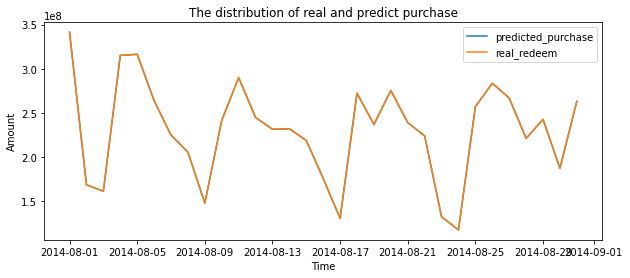

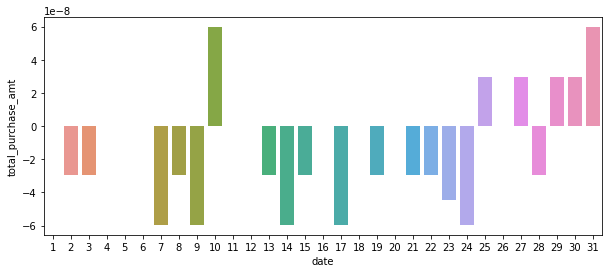

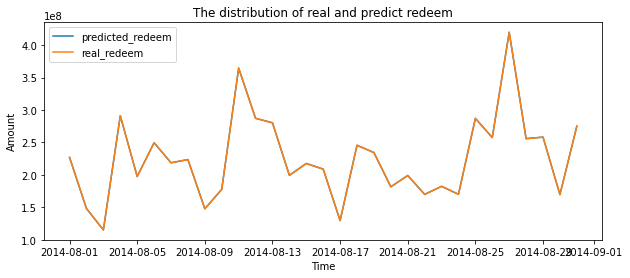

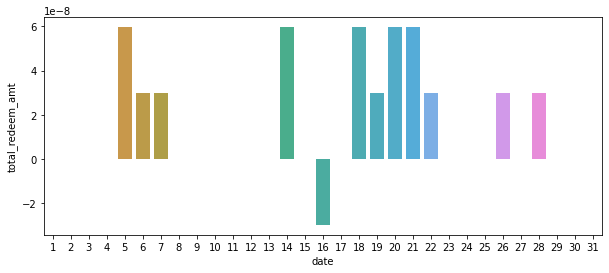

In [65]:
visual(result_purchase_lr, result_redeem_lr, testset)

In [66]:
result_purchase_lr = generate_online_result(data, [x for x in trainset.columns if x not in ['total_purchase_amt','total_redeem_amt','date']], LinearRegression(),'total_purchase_amt')
result_redeem_lr = generate_online_result(data, [x for x in trainset.columns if x not in ['total_purchase_amt','total_redeem_amt','date']], LinearRegression(),'total_redeem_amt')

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

### 九月份预测效果图(线性)

In [ ]:
trainset, testset = split_data_online(data)
draw_result(result_purchase_lr, result_redeem_lr, testset)

In [ ]:
normalize_upload_file(result_purchase_lr, result_redeem_lr, testset).to_csv('20190612_only_is.csv',index=False,header=None)

线上预测效果：
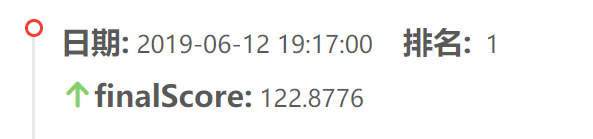

## 二、多模型对比

In [67]:
def multi_model_eva(data, types:str = 'purchase'):
    results = pd.DataFrame()
    for model in [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor(), GradientBoostingRegressor(), MLPRegressor(solver='lbfgs'), xgb.XGBRegressor(objective='reg:squarederror')]:
        if results.empty:
            results = draw_eva_table(week_evalution_single(data, model, types)).rename(columns={0: repr(model).split('(')[0]})
        else:
            results = pd.merge(results, \
                               draw_eva_table(week_evalution_single(data, model, types)).rename(columns={0: repr(model).split('(')[0]}), on='interval')
    results = results[['interval'] + [x for x in results.columns if x != 'interval']]
    return results

In [68]:
add_two_df(multi_model_eva(data, 'purchase'), multi_model_eva(data, 'redeem'))

,interval,LinearRegression,DecisionTreeRegressor,RandomForestRegressor,GradientBoostingRegressor,MLPRegressor,XGBRegressor
0,2014-08-01,310.0,296.707518,303.329062,304.240372,309.974081,296.487576
1,2014-07-25,310.0,297.277135,299.686251,302.447424,309.962278,293.512947
2,2014-07-18,310.0,295.707015,299.380003,302.780263,309.961659,295.605066
3,2014-07-11,310.0,295.930018,298.380744,302.084448,309.936014,295.843357
4,2014-07-04,310.0,283.267257,295.842376,300.829760,309.954779,289.779353
5,2014-06-27,300.0,276.958107,287.323883,290.390902,299.919095,281.176806
6,2014-06-20,300.0,277.736022,287.988069,290.290575,299.941147,282.316680


## 三、劣汰后特征对比

In [69]:
data_purchase = pd.read_csv('purchase_feature_droped_0614.csv')
data_purchase['date'] = pd.to_datetime(data_purchase['date'])

In [71]:
data_redeem = pd.read_csv('redeem_feature_droped_0614.csv')
data_redeem['date'] = pd.to_datetime(data_redeem['date'])

In [72]:
trainset_purchase, testset_purchase = split_data_underline(data_purchase)
result_purchase_lr = generate_under_result(data_purchase, [x for x in data_purchase.columns
                                                           if x not in ['total_purchase_amt','total_redeem_amt','date']], 
                                           target='total_purchase_amt')

In [73]:
trainset_redeem, testset_redeem = split_data_underline(data_redeem)
result_redeem_lr = generate_under_result(data_redeem, [x for x in data_redeem.columns
                                                           if x not in ['total_purchase_amt','total_redeem_amt','date']], 
                                           target='total_redeem_amt')

In [74]:
total_AE(result_purchase_lr, result_redeem_lr, testset_purchase['total_purchase_amt'], testset_redeem['total_redeem_amt'])

183.3154666171862

In [75]:
add_two_df(multi_model_eva(data_purchase, 'purchase'), multi_model_eva(data_redeem, 'redeem'))

,interval,LinearRegression,DecisionTreeRegressor,RandomForestRegressor,GradientBoostingRegressor,MLPRegressor,XGBRegressor
0,2014-08-01,183.315467,173.960508,177.182330,179.678371,175.363453,165.113740
1,2014-07-25,176.027316,164.963520,166.790448,173.391373,173.529703,156.770595
2,2014-07-18,185.485582,179.782695,183.249546,181.383655,180.282732,170.092699
3,2014-07-11,185.081070,164.004961,171.522315,175.720677,174.145171,172.067106
4,2014-07-04,176.494188,155.649007,165.214535,163.995968,171.087893,150.045028
5,2014-06-27,173.424900,162.497109,180.233427,178.267963,167.971221,163.495178
6,2014-06-20,162.090577,171.492970,168.097818,165.046654,159.878999,160.670695


### 八月份预测效果(线性)

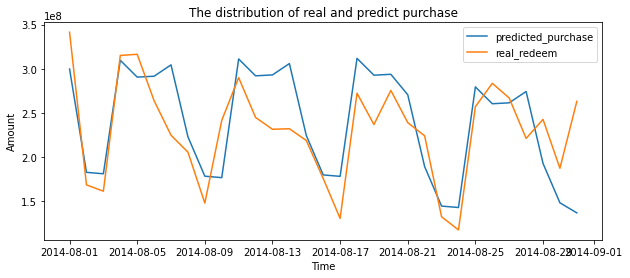

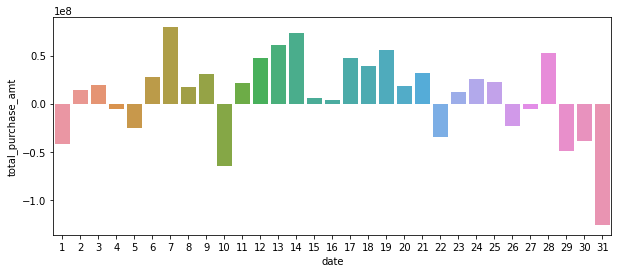

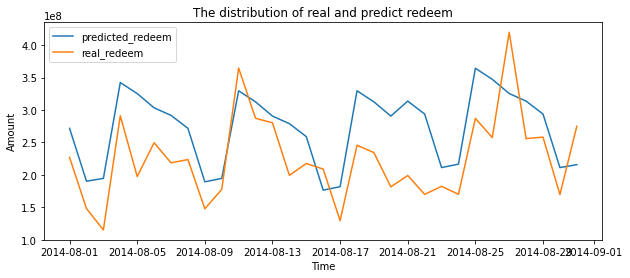

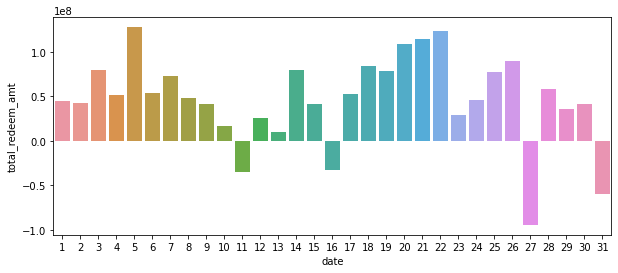

In [76]:
trainset, testset = split_data_underline(data)
visual(result_purchase_lr, result_redeem_lr, testset)

In [77]:
result_purchase_lr = generate_online_result(data_purchase, [x for x in data_purchase.columns if x not in ['total_purchase_amt','total_redeem_amt','date']], LinearRegression(),'total_purchase_amt')
result_redeem_lr = generate_online_result(data_redeem, [x for x in data_redeem.columns if x not in ['total_purchase_amt','total_redeem_amt','date']], LinearRegression(),'total_redeem_amt')

### 生成线上效果（线性）
可以看到28号很高（work in Sunday）

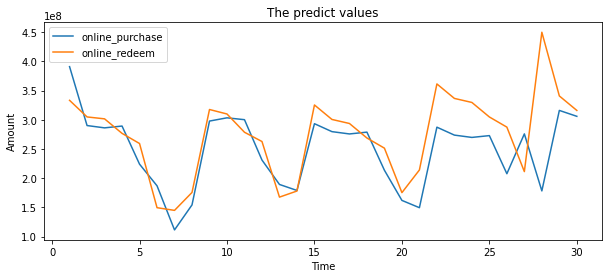

In [78]:
trainset, testset = split_data_online(data)
draw_result(result_purchase_lr, result_redeem_lr, testset)

purchase feature

> 'dis_to_nowork', 'dis_to_work', 'dis_from_work', 'purchase_weekdayrate',
       'redeem_dayrate', 'weekday_onehot_5', 'weekday_onehot_6',
       'dis_from_nowork', 'is_holiday', 'weekday_onehot_1', 'weekday_onehot_2',
       'weekday_onehot_0', 'dis_from_middleofweek', 'dis_from_holiendday',
       'weekday_onehot_3', 'is_lastday_of_holiday', 'is_firstday_of_holiday',
       'weekday_onehot_4', 'is_worked_yestday', 'is_second_week',
       'is_third_week', 'dis_from_startofmonth', 'dis_from_holiday',
       'dis_to_nowork%%%%dis_from_purchase_peak', 'total_purchase_amt',
       'total_redeem_amt', 'date'

Redeem feature

>'is_work', 'dis_from_redeem_valley', 'purchase_weekdayrate',
       'redeem_dayrate', 'weekday_onehot_5', 'is_gonna_work_tomorrow',
       'is_holiday', 'dis_from_nowork', 'weekday_onehot_0', 'weekday_onehot_1',
       'is_firstday_of_holiday', 'weekday_onehot_2', 'is_lastday_of_holiday',
       'dis_from_holiday', 'is_work_on_sunday', 'is_firstday_of_work',
       'is_secday_of_month', 'dis_from_holiendday',
       'dis_from_redeem_valley%%%%dis_from_redeem_peak', 'total_purchase_amt',
       'total_redeem_amt', 'date'

In [79]:
normalize_upload_file(result_purchase_lr, result_redeem_lr, testset).to_csv('20190614_droped.csv',index=False,header=None)

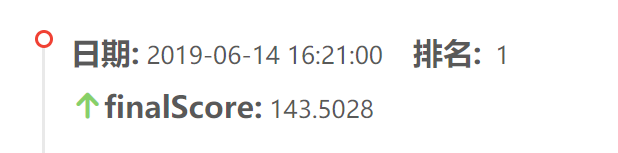

### 生成线上效果（MLP）

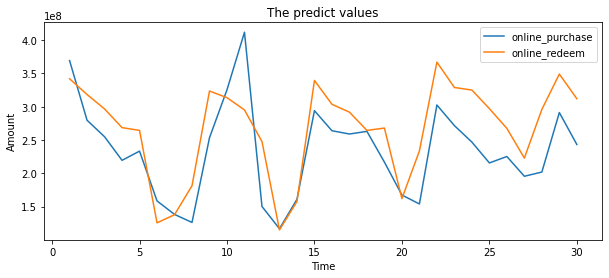

In [80]:
result_purchase_lr = generate_online_result(data_purchase, [x for x in data_purchase.columns 
                                                            if x not in ['total_purchase_amt','total_redeem_amt','date']], 
                                            MLPRegressor(solver='lbfgs'),'total_purchase_amt')
result_redeem_lr = generate_online_result(data_redeem, [x for x in data_redeem.columns 
                                                        if x not in ['total_purchase_amt','total_redeem_amt','date']], 
                                          MLPRegressor(solver='lbfgs'),'total_redeem_amt')
trainset, testset = split_data_online(data)
draw_result(result_purchase_lr, result_redeem_lr, testset)

In [81]:
normalize_upload_file(result_purchase_lr, result_redeem_lr, testset).to_csv('20190614_droped_MLP.csv',index=False,header=None)

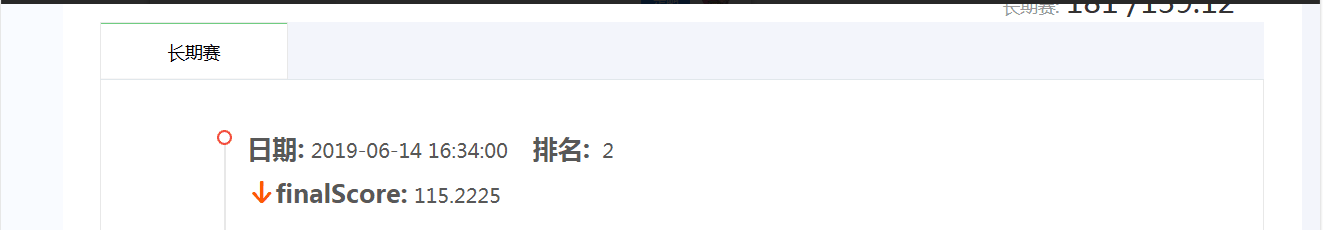

### 生成线上效果（Xgboost）

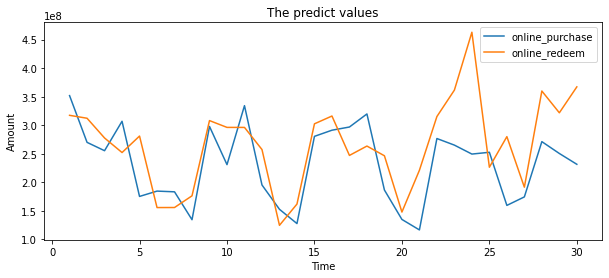

In [82]:
result_purchase_lr = generate_online_result(data_purchase, [x for x in data_purchase.columns 
                                                            if x not in ['total_purchase_amt','total_redeem_amt','date']], 
                                            xgb.XGBRegressor(objective='reg:squarederror'),'total_purchase_amt')
result_redeem_lr = generate_online_result(data_redeem, [x for x in data_redeem.columns 
                                                        if x not in ['total_purchase_amt','total_redeem_amt','date']], 
                                          xgb.XGBRegressor(objective='reg:squarederror'),'total_redeem_amt')
trainset, testset = split_data_online(data)
draw_result(result_purchase_lr, result_redeem_lr, testset)

In [83]:
normalize_upload_file(result_purchase_lr, result_redeem_lr, testset).to_csv('20190615_droped_XGB.csv',index=False,header=None)

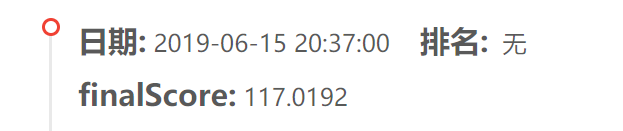

## 四、AIC模型平均

In [84]:
purchase_features, purchase_weight = multi_model(data_purchase, model=LinearRegression(), types = 'purchase')

In [85]:
redeem_features, redeem_weight = multi_model(data_redeem, model=LinearRegression(), types = 'redeem')

In [86]:
def eva_for_aic(data_purchase, purchase_features, purchase_weight):
    results = pd.DataFrame()
    for index, feature in enumerate(purchase_features):
        if results.empty:
            results = scale_df(multi_model_eva(data_purchase[['date'] + labels + feature], 'purchase'), 
                               eta = purchase_weight[index])
        else:
            results = add_two_df(results, multi_model_eva(data_purchase[['date'] + labels + feature], 'purchase')
                                 , left_a = 1,
                                 right_a = purchase_weight[index])
    return results

In [87]:
add_two_df(eva_for_aic(data_purchase, purchase_features, purchase_weight), 
           eva_for_aic(data_redeem, redeem_features, redeem_weight))

,interval,LinearRegression,DecisionTreeRegressor,RandomForestRegressor,GradientBoostingRegressor,MLPRegressor,XGBRegressor
0,2014-08-01,192.413681,174.576136,177.135227,180.141997,194.212075,176.181109
1,2014-07-25,167.137882,164.109786,164.997397,162.865453,171.632691,164.689889
2,2014-07-18,163.949657,163.393169,165.816790,165.258337,165.489371,165.481805
3,2014-07-11,167.407740,167.834972,173.078409,173.096539,170.041996,169.160188
4,2014-07-04,156.777850,148.999091,156.264291,158.212923,160.096584,148.532692
5,2014-06-27,171.372977,164.457620,173.081129,172.232359,172.719072,164.957719
6,2014-06-20,174.807922,158.391901,172.046670,172.775123,176.951822,162.531334


## 五、针对残差建模

In [88]:
data_purchase = pd.read_csv('0615_residual_purchase_origined.csv')
data_purchase['date'] = pd.to_datetime(data_purchase['date'])

In [89]:
data_redeem = pd.read_csv('0615_residual_redeem_origined.csv')
data_redeem['date'] = pd.to_datetime(data_redeem['date'])

In [91]:
base = pd.read_csv('base.csv')

In [97]:
def generate_residual_result(data, base, model=LinearRegression(), types = 'purchase', split_time = datetime.date(2014,8,1)):
    a_month = relativedelta(months=1)
    trainset = data[(datetime.date(2014,4,1) <= data['date'].dt.date) & (data['date'].dt.date < split_time)]
    testset = data[(split_time <= data['date'].dt.date) & (data['date'].dt.date < split_time + a_month)]
    feature = [x for x in data_purchase.columns 
               if x not in ['total_purchase_amt','total_redeem_amt','date']]
    model.fit(X=trainset[feature], y=trainset['total_' + types + '_amt'])
    result_purchase_rate = model.predict(testset[feature])
    
    base['date'] = pd.to_datetime(base['date'], format= "%Y%m%d")
    result_purchase_cycle = np.array(base[(base['date'].dt.date >= split_time)
                                          &(base['date'].dt.date < split_time + a_month)]['total_'+types+'_predicted_by_cycle'])
    result_purchase_residual =  result_purchase_rate * np.array(result_purchase_cycle)
    return result_purchase_residual

In [98]:
def generate_evaluate_for_residual(model=LinearRegression()):
    result = []
    for i in [datetime.date(2014, 8, 1), datetime.date(2014, 7, 25), datetime.date(2014, 7, 18), datetime.date(2014, 7, 11), 
              datetime.date(2014, 7, 4), datetime.date(2014, 6, 27), datetime.date(2014, 6,20)]:
        result_purchase_residual = generate_residual_result(data_purchase, base, model=model, types='purchase', split_time = i)
        result_redeem_residual = generate_residual_result(data_purchase, base, model=model, types='redeem', split_time= i)
        a_month = relativedelta(months=1)
        testset = data[(data['date'].dt.date >= i) & (data['date'].dt.date < i + a_month)]
        real_purchase = testset['total_purchase_amt']
        real_redeem = testset['total_redeem_amt']
        result.append(total_AE(result_purchase_residual, result_redeem_residual, real_purchase, real_redeem))
    return pd.DataFrame(result)

In [99]:
def multi_model_eva_for_residual():
    results = pd.DataFrame()
    for model in [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor(), GradientBoostingRegressor(), MLPRegressor(solver='lbfgs'), xgb.XGBRegressor(objective='reg:squarederror')]:
        if results.empty:
            results = draw_eva_table(generate_evaluate_for_residual(model)).rename(columns={0: repr(model).split('(')[0]})
        else:
            results = pd.merge(results, \
                               draw_eva_table(generate_evaluate_for_residual(model)).rename(columns={0: repr(model).split('(')[0]}))
    results = results[['interval'] + [x for x in results.columns if x != 'interval']]
    return results

In [100]:
def generate_evaluate_for_cycle():
    result = []
    for i in [datetime.date(2014, 8, 1), datetime.date(2014, 7, 25), datetime.date(2014, 7, 18), datetime.date(2014, 7, 11), 
                  datetime.date(2014, 7, 4), datetime.date(2014, 6, 27), datetime.date(2014, 6,20)]:
        a_month = relativedelta(months=1)
        testset = base[(base['date'].dt.date >= i) & (base['date'].dt.date < i + a_month)].reset_index(drop=True)
        result_purchase_residual = testset['total_purchase_predicted_by_cycle']
        result_redeem_residual = testset['total_redeem_predicted_by_cycle']
        testset = data[(data['date'].dt.date >= i) & (data['date'].dt.date < i + a_month)].reset_index(drop=True)
        real_purchase = testset['total_purchase_amt']
        real_redeem = testset['total_redeem_amt']
        result.append(total_AE(result_purchase_residual, result_redeem_residual, real_purchase, real_redeem))
    return pd.DataFrame(result).rename(columns={0: 'PureTimeSeries'})

In [101]:
pd.merge(multi_model_eva_for_residual(), draw_eva_table(generate_evaluate_for_cycle()))

,interval,LinearRegression,DecisionTreeRegressor,RandomForestRegressor,GradientBoostingRegressor,MLPRegressor,XGBRegressor,PureTimeSeries
0,2014-08-01,0.0,0.0,0.0,0.0,0.0,0.0,151.273267
1,2014-07-25,0.0,0.0,0.0,0.0,0.0,0.0,130.332636
2,2014-07-18,0.0,0.0,0.0,0.0,0.0,0.0,146.001418
3,2014-07-11,0.0,0.0,0.0,0.0,0.0,0.0,142.254290
4,2014-07-04,0.0,0.0,0.0,0.0,0.0,0.0,134.329465
5,2014-06-27,0.0,0.0,0.0,0.0,0.0,0.0,143.799652
6,2014-06-20,0.0,0.0,0.0,0.0,0.0,0.0,142.442084


### (1) 只使用周期因子在8月份的预测效果

In [102]:
_, testset = split_data_underline(data)

In [103]:
real_purchase = testset['total_purchase_amt']
real_redeem = testset['total_redeem_amt']

In [104]:
result_purchase_cycle = np.array(base[(base['date'].dt.date >= datetime.date(2014,8,1))&(base['date'].dt.date < datetime.date(2014,9,1))]['total_purchase_predicted_by_cycle'])
result_redeem_cycle = np.array(base[(base['date'].dt.date >= datetime.date(2014,8,1))&(base['date'].dt.date < datetime.date(2014,9,1))]['total_redeem_predicted_by_cycle'])
total_AE(result_purchase_cycle, result_redeem_cycle, real_purchase, real_redeem)

151.27326707508362

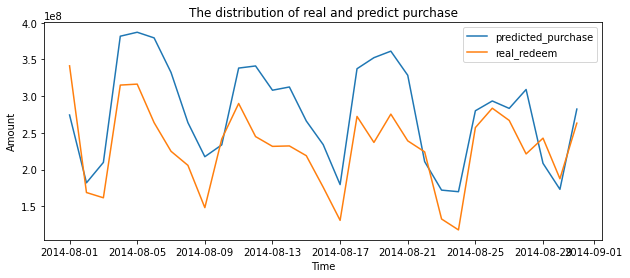

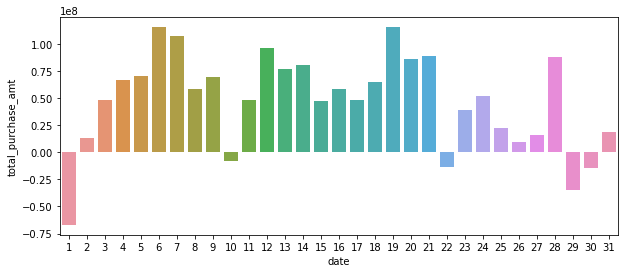

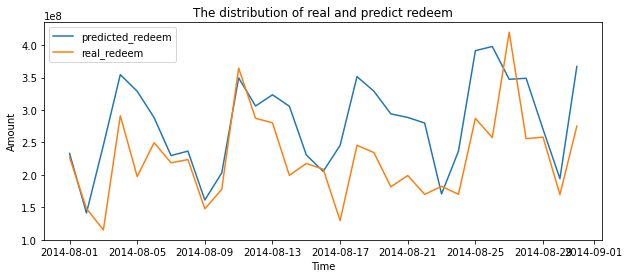

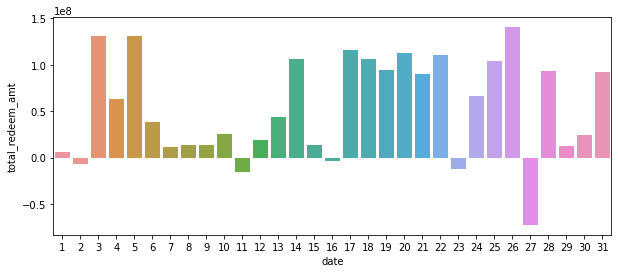

In [105]:
trainset, testset = split_data_underline(data)
visual(result_purchase_cycle, result_redeem_cycle, testset)

### (2) 只使用周期因子+预测残差在8月份的预测效果（比单纯用因子好）

In [106]:
trainset_purchase, testset_purchase = split_data_underline(data_purchase)
result_purchase_rate = generate_under_result(data_purchase, [x for x in data_purchase.columns
                                                           if x not in ['total_purchase_amt','total_redeem_amt','date']], 
                                           target='total_purchase_amt')

In [107]:
trainset_redeem, testset_redeem = split_data_underline(data_redeem)
result_redeem_rate = generate_under_result(data_redeem, [x for x in data_redeem.columns
                                                           if x not in ['total_purchase_amt','total_redeem_amt','date']], 
                                           target='total_redeem_amt')

In [108]:
total_AE(result_purchase_rate * result_purchase_cycle, result_redeem_rate * result_redeem_cycle, real_purchase, real_redeem)

0.0

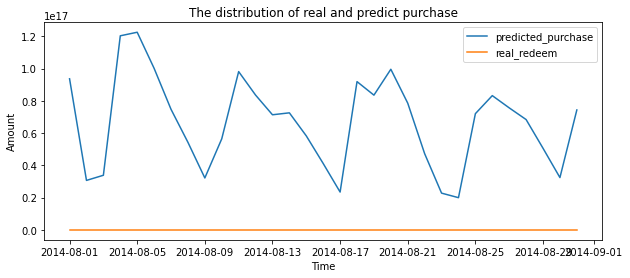

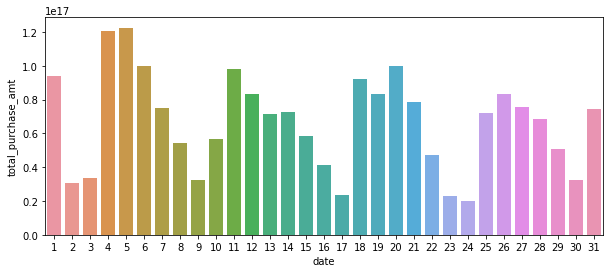

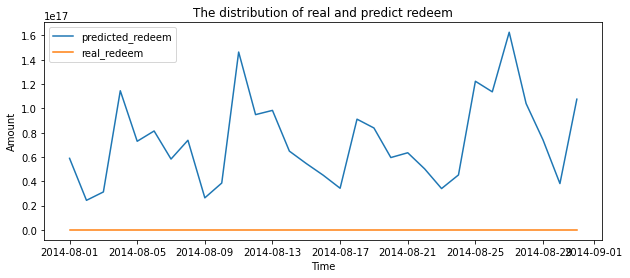

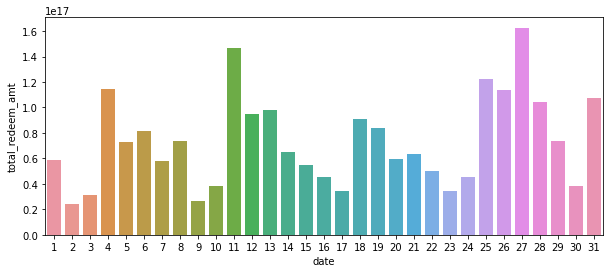

In [109]:
trainset, testset = split_data_underline(data)
visual(result_purchase_rate * result_purchase_cycle, result_redeem_rate * result_redeem_cycle, testset)

### (3) 生成线上结果

In [110]:
trainset_purchase, testset_purchase = split_data_online(data_purchase)
result_purchase_rate = generate_online_result(data_purchase, [x for x in data_purchase.columns
                                                           if x not in ['total_purchase_amt','total_redeem_amt','date']], 
                                           target='total_purchase_amt')

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
trainset_redeem, testset_redeem = split_data_online(data_redeem)
result_redeem_rate = generate_online_result(data_redeem, [x for x in data_redeem.columns
                                                           if x not in ['total_purchase_amt','total_redeem_amt','date']], 
                                           target='total_redeem_amt')

In [ ]:
# 修正一下预测结果试试
result_purchase_rate = result_purchase_rate / np.mean(result_purchase_rate)
result_redeem_rate = result_redeem_rate / np.mean(result_redeem_rate)

In [111]:
result_purchase_cycle = np.array(base[(base['date'].dt.date >= datetime.date(2014,9,1))&(base['date'].dt.date < datetime.date(2014,10,1))]['total_purchase_predicted_by_cycle'])
result_redeem_cycle = np.array(base[(base['date'].dt.date >= datetime.date(2014,9,1))&(base['date'].dt.date < datetime.date(2014,10,1))]['total_redeem_predicted_by_cycle'])

In [112]:
result_purchase_residual = result_purchase_rate * result_purchase_cycle

ValueError: operands could not be broadcast together with shapes (31,) (30,) 

In [113]:
result_redeem_residual = result_redeem_rate * result_redeem_cycle

ValueError: operands could not be broadcast together with shapes (31,) (30,) 

#### 月份周期因子线上结果（135）

In [ ]:
draw_result(result_purchase_cycle, result_redeem_cycle, testset_redeem)

#### 残差处理后结果

In [ ]:
draw_result(result_purchase_residual, result_redeem_residual, testset_redeem)

In [ ]:
normalize_upload_file(result_purchase_residual, result_redeem_residual, testset_redeem).to_csv('20190622_residual_liner.csv',index=False,header=None)

#### 仅用与修正节假日的结果

In [ ]:
result_score135 = pd.read_csv('result/timeseries0606.csv',header=None)

In [ ]:
result_residual = normalize_upload_file(result_purchase_residual, result_redeem_residual, testset_redeem).reset_index(drop=True)

In [ ]:
result_residual['date'] = result_residual['date'].astype(int)

In [ ]:
days_need_to_change = [
    20140906,
    20140907,
    20140908,
    20140928
]

In [ ]:
for index,row in result_score135.iterrows():
    if row[0] in days_need_to_change:
        result_score135.loc[index, 1] =  result_residual.loc[index, 'total_purchase_amt']
        result_score135.loc[index, 2] =   result_residual.loc[index, 'total_redeem_amt']

In [ ]:
result_score135.to_csv('result/135_fixed_by_residual_0621.csv',index=False,header=None)